In [1]:
import numpy as np
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import visdcc

from jupyter_dash import JupyterDash
from dash import dcc, html, Dash
from dash.dependencies import Input, Output

plt.style.use('ggplot')

/Users/kevin/.conda/envs/hihi/lib/python3.10/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/kevin/.conda/envs/hihi/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [2]:
df = pd.read_feather('data/clean_data_full.ftr')

print(df.shape)
print(f"Total items: {len(df['product_name'].unique())}, Total Orders: {len(df['order_id'].unique())}")
df.head()

(1384617, 2)
Total items: 39123, Total Orders: 131209


,order_id,product_name
0,1,Bulgarian Yogurt
1,1,Organic 4% Milk Fat Whole Milk Cottage Cheese
2,1,Organic Celery Hearts
3,1,Cucumber Kirby
4,1,Lightly Smoked Sardines in Olive Oil


In [3]:
# filter out orders have only 1 item & buyers have 1 order
mask = df['order_id'].value_counts()
df = df[df['order_id'].isin(mask.index[mask > 1])]

mask = df.groupby('product_name')['order_id'].count()
df = df[df['product_name'].isin(mask.index[mask > 1])]

In [4]:
df.head()

,order_id,product_name
0,1,Bulgarian Yogurt
1,1,Organic 4% Milk Fat Whole Milk Cottage Cheese
2,1,Organic Celery Hearts
3,1,Cucumber Kirby
4,1,Lightly Smoked Sardines in Olive Oil


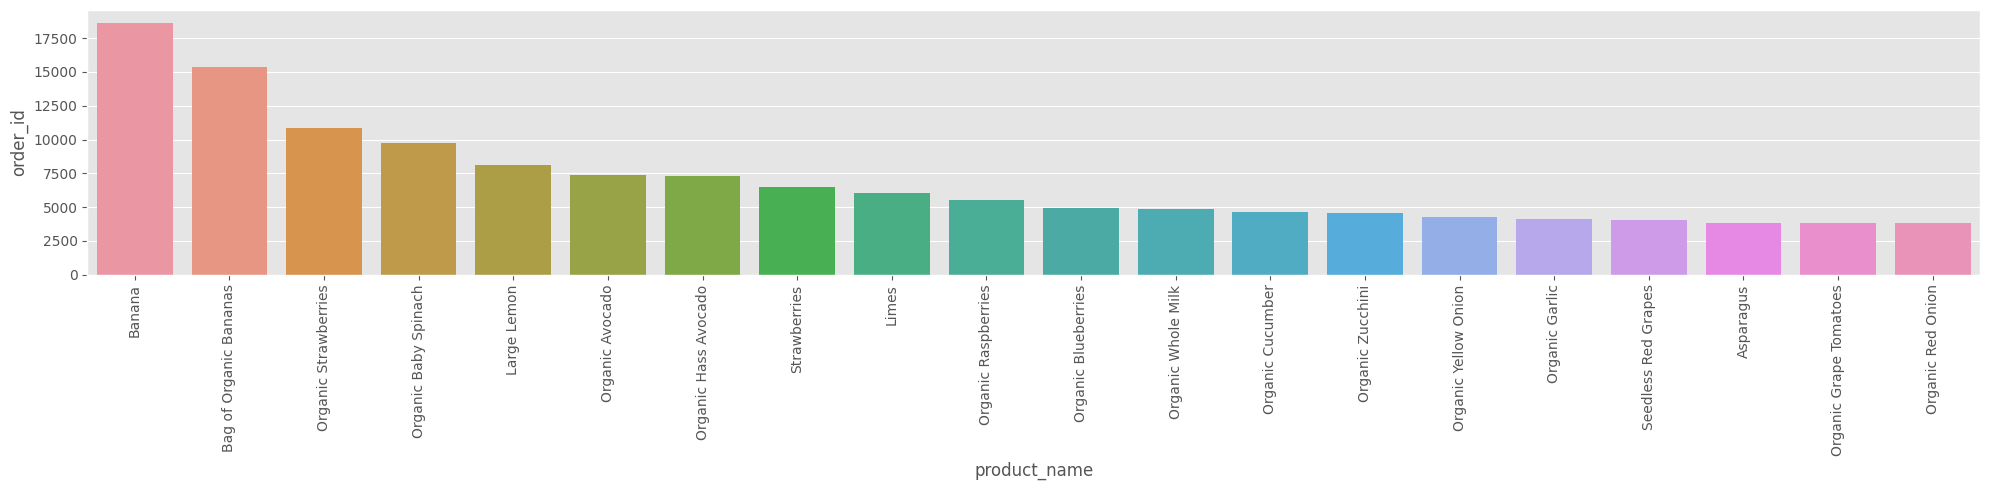

In [5]:
tmp = df.groupby('product_name')['order_id'].count().reset_index()

plt.figure(figsize=(20, 5))
ax = sns.barplot(data=tmp.sort_values(by='order_id', ascending=False).head(20), x='product_name', y='order_id')
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.savefig('media/fig3_top_products.png')

In [6]:
df_txn = df.groupby('order_id')['product_name'].apply(set).reset_index()
df_txn

,order_id,product_name
0,1,"{Bulgarian Yogurt, Organic Whole String Cheese..."
1,36,"{Super Greens Salad, Organic Garnet Sweet Pota..."
2,38,"{Organic Raw Unfiltered Apple Cider Vinegar, G..."
3,96,"{Organic Pomegranate Kernels, Organic Blueberr..."
4,98,"{Uncured Genoa Salami, Geranium Liquid Dish So..."
...,...,...
124355,3421049,"{Organic Whole Grain Wheat English Muffins, Or..."
124356,3421056,"{Brioche Buns, Total Plain Greek Strained Yogu..."
124357,3421058,"{Sweet Potatoes, Extralean Ground Turkey Breas..."
124358,3421063,{No Salt Added Gluten-Free Blue Chips Made wit...


In [7]:
te = TransactionEncoder()
te_data = te.fit_transform(df_txn['product_name'].values, sparse=True)
df_te = pd.DataFrame.sparse.from_spmatrix(te_data, columns=te.columns_)
print(f'No. Transactions: {df_te.shape[0]:,.0f}')

No. Transactions: 124,360


In [8]:
support_dist = (df_te.sum(axis=0) / df_te.shape[0]).sort_values(ascending=False).rename('values').reset_index()
support_dist.describe(percentiles=[.25, .5, .75, .95, .99])

,values
count,31178.000000
mean,0.000353
std,0.001990
min,0.000016
25%,0.000024
50%,0.000064
75%,0.000201
95%,0.001246
99%,0.004650
max,0.149944


In [9]:
support_ranges_ = np.arange(0.0008, 0.0012, 0.0001)
confidence_ranges_ = np.arange(0.3, 0.7, 0.1)

report = pd.DataFrame(columns=['support_level', 'confidence_level', 'no_rules'])
for s in support_ranges_:
    for c in tqdm(confidence_ranges_, desc=f'Support Threshold: {s:,.5f}'):
        frequent_itemsets = fpgrowth(df_te, min_support=s, use_colnames=True)
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=c)
        tmp = pd.DataFrame({'support_level': [s:,.5f], 'confidence_level': [c], 'no_rules': [rules.shape[0]]})
        report = pd.concat([report, tmp])

Support Threshold: 0.00110: 100%|█████████████████| 4/4 [00:35<00:00,  8.77s/it]


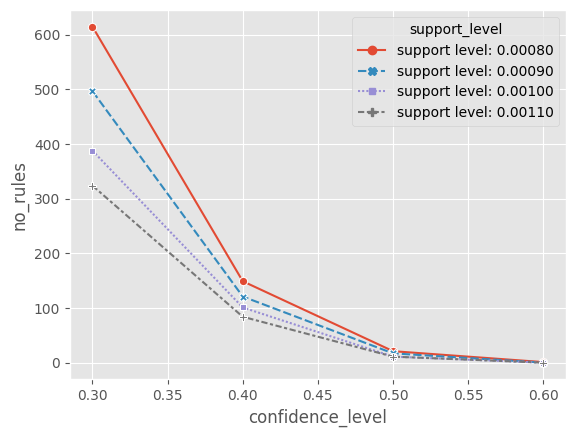

In [10]:
sns.lineplot(data=report.reset_index(drop=True), x='confidence_level', y='no_rules',
             hue='support_level', style='support_level', markers=True)
plt.savefig('media/fig4_threshold.png')

In [11]:
frequent_itemsets = fpgrowth(df_te, min_support=0.0009, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.4)
print(f'No. Rules: {rules.shape[0]}')

No. Rules: 121


In [12]:
for i in ['antecedents', 'consequents']:
    rules[f'combo_{i}'] = rules[i].map(lambda x: len(x))
    rules[i] = rules[i].map(lambda x: ' + '.join(tuple(x)))
rules['combo'] = rules['combo_antecedents'].astype(str) + ' - ' + rules['combo_consequents'].astype(str)
rules.drop(columns=['combo_antecedents', 'combo_consequents'], inplace=True)

In [13]:
rules['combo'].value_counts()

2 - 1    106
3 - 1     10
1 - 1      5
Name: combo, dtype: int64

In [14]:
rules.sort_values('confidence', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,combo
13,Organic Strawberries + Organic Hass Avocado + ...,Bag of Organic Bananas,0.003064,0.123633,0.001833,0.598425,4.840335,0.001455,2.182326,3 - 1
36,Organic Strawberries + Organic Hass Avocado + ...,Bag of Organic Bananas,0.001705,0.123633,0.000957,0.561321,4.540218,0.000746,1.997740,3 - 1
23,Organic Strawberries + Organic Cucumber + Orga...,Bag of Organic Bananas,0.002059,0.123633,0.001126,0.546875,4.423374,0.000871,1.934051,3 - 1
114,Organic Hass Avocado + Organic Kiwi,Bag of Organic Bananas,0.002798,0.123633,0.001528,0.545977,4.416111,0.001182,1.930226,2 - 1
110,Organic Navel Orange + Organic Raspberries,Bag of Organic Bananas,0.002243,0.123633,0.001214,0.541219,4.377623,0.000937,1.910206,2 - 1
...,...,...,...,...,...,...,...,...,...,...
77,Strawberries + Seedless Red Grapes,Banana,0.004366,0.149944,0.001753,0.401473,2.677493,0.001098,1.420248,2 - 1
76,Organic Avocado + Organic Baby Spinach + Large...,Banana,0.002686,0.149944,0.001078,0.401198,2.675655,0.000675,1.419594,3 - 1
61,Organic Large Extra Fancy Fuji Apple + Organic...,Organic Strawberries,0.003490,0.087271,0.001399,0.400922,4.593994,0.001095,1.523556,2 - 1
82,Organic Granny Smith Apple + Organic Cucumber,Bag of Organic Bananas,0.002509,0.123633,0.001005,0.400641,3.240567,0.000695,1.462174,2 - 1


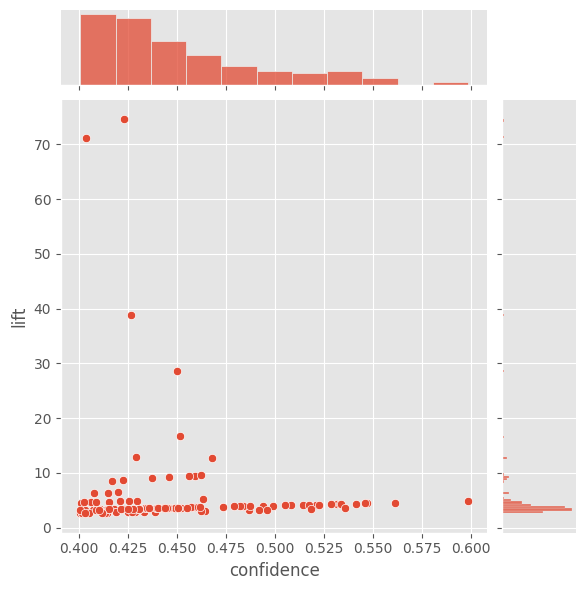

In [15]:
sns.jointplot(data=rules, x='confidence', y='lift')
plt.savefig('media/fig6_correlation.png')

In [16]:
node_list = list(set(rules['antecedents'].unique().tolist() + rules['consequents'].unique().tolist()))
nodes = [{'id': node_name, 'label': node_name, 'shape': 'dot', 'size': 7} for i, node_name in enumerate(node_list)]
edges = []
for row in rules.to_dict(orient='records'):
    source, target = row['antecedents'], row['consequents']
    edges.append({
        'id': source + "__" + target,
        'from': source,
        'to': target,
        'width': row['lift'],
    })

In [17]:
app = JupyterDash(__name__)
app.layout = html.Div([
    visdcc.Network(id='net', data={'nodes': nodes, 'edges': edges}, options=dict(height='1000px', width='100%')),
    dcc.RadioItems(id='color', value='Red')
])

app.run_server()

Dash app running on http://127.0.0.1:8050/


/Users/kevin/.conda/envs/hihi/lib/python3.10/site-packages/jupyter_dash/jupyter_app.py:310: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  thread.setDaemon(True)
